# I tried to get this to work on feb 13 2022 and it has a problem with values being on cuda and cpu at the same time.

For the continuous action space lunar lander problem you can no longer use the DQN.
The DQN outputs a Q value prediction for each action at each state.

With a continuous action space you can no longer do this. 

Instead here is a policy gradient implementation. 

# Deep Deterministic Policy Gradient

Predict action given the input state

Start an episode

Use policy network with the state as input to predict the next action

Take the action to get to the new state.

Create a memory buffer of these transitions

Have a critic network, calculate the q value for the state and action.
Have a target critic network calculate the q value for the new state (use also the action at the new state decided by the actor_target network.

Train the critic network based on the difference between these two. Update every so often. Temporal difference learning. 

Create the objective function - in this case you're trying to maximise the output of the critic

Update the actor
You just differentiate the critic wrt the actor (and go in the negative direction - gradient ascent)


Best blog on pytorch and the fundamentals of backwards() and the graph 
https://blog.paperspace.com/pytorch-101-understanding-graphs-and-automatic-differentiation/

https://medium.com/@thechrisyoon/deriving-policy-gradients-and-implementing-reinforce-f887949bd63

https://towardsdatascience.com/deep-deterministic-policy-gradients-explained-2d94655a9b7b

https://towardsdatascience.com/solving-lunar-lander-openaigym-reinforcement-learning-785675066197

the total policy approaches summary
https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html

Good blog on DDPG
https://pemami4911.github.io/blog/2016/08/21/ddpg-rl.html

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import gym

from torch.nn.functional import mse_loss
from torch import optim

import os
import time
import datetime

%matplotlib inline

In [17]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# Set up the environment
env = gym.make('LunarLanderContinuous-v2')

In [20]:
# Test run of the lander.
env.reset()
for i in range(0,100):
    env.render()
    state, reward, done, _ = env.step(env.action_space.sample())
env.close()

In [21]:
# Experience replay

class ReplayBuffer(object):
    '''
    This is a collection of transitions. (state, action reward sets)
    inputs
    size - defines the size of the storage.
    memory - is the list that contains the transitions.
    pointer - this identifies the current transition. 
    '''
    
    def __init__(self,size):
        self.size = size
        self.memory = []
        self.pointer = 0
        
    def add_to_memory(self, transition):
        if len(self.memory) == self.size:
            self.memory[int(self.pointer)] = transition 
            self.pointer = (self.pointer + 1)% self.size
        else:
            self.memory.append(transition) 
            
  # sample from the storage a batch
    def sample(self, batch_size):
        ind = np.random.randint(0, len(self.memory), batch_size)
        # states, next statesm actions and rewards are placed in separate lists
        # batch dones defines if the game is finished or not. 
        batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [],[],[],[],[]
        for i in ind:
            state, next_state, action, reward, done = self.memory[i]
            batch_states.append(np.array(state, copy=False))
            batch_next_states.append(np.array(next_state, copy=False))
            batch_actions.append(np.array(action, copy=False))
            batch_rewards.append(np.array(reward, copy=False))
            batch_dones.append(np.array(done, copy=False))

        return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)
    
    def __len__(self):
        return len(self.memory)
        

In [22]:
# The policy network

class policy_net(nn.Module):
    '''
    state_dim - dimension of the state
    action_dim - dimension of the action (note this doesn't mean 
    number of discrete actions, it means number of continuous values that represent the action space)
    max_action - if you need to clip the action to a certain range
    '''
    def __init__(self, state_dim, action_dim, max_action):
        super(policy_net, self).__init__()
        self.max_action = max_action
        self.main= nn.Sequential(
        nn.Linear(state_dim, 400),
        nn.Linear(400, 300),
        nn.Linear(300, action_dim),
        nn.Tanh()
        # as tanh is between 0 and 1 if you multiply by max action you'll be between -max and +max action
        )
    
    def forward(self, input):
        output = self.main(input)
        output = output*self.max_action
        return output
    

In [23]:
# critic network

class critic_net(nn.Module):
    
    def __init__(self, state_dim, action_dim):
        super(critic_net, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(state_dim + action_dim, 400),
            nn.Linear(400, 300),
            # for a combined action and state just output one Q value.
            nn.Linear(300, 1)
        )
        
    def forward(self, state, action):
        input_combined = torch.cat([state, action], 1)
        output = self.main(input_combined)
        return output 

In [24]:
def evaluate_policy(policy, eval_episodes=10):
    avg_reward = 0.
    for _ in range(eval_episodes):
        obs = env.reset()
        done = False
        while not done:
            
         
            state = torch.Tensor(obs.reshape(1, -1)).to(device)
            action = policy(state).cpu().data.numpy().flatten()
            
            obs, reward, done, _ = env.step(action)
            avg_reward += reward
    avg_reward /= eval_episodes
    print ("---------------------------------------")
    print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
    print ("---------------------------------------")
    return avg_reward

In [25]:
state_dim = env.observation_space.shape[0]
print('state dim {}'.format(state_dim))
action_dim = env.action_space.shape[0]
print('action dim {}'.format(action_dim))
max_action = float(env.action_space.high[0])
print('max action {}'.format(max_action))

state dim 8
action dim 2
max action 1.0


In [26]:
env_name = "LunarLanderContinuous-v2" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number

In [27]:
file_name = "%s_%s_%s" % ("TD3", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: TD3_LunarLanderContinuous-v2_0
---------------------------------------


In [28]:
#if not os.path.exists("./results"):
#    os.makedirs("./results")
#if save_models and not os.path.exists("./pytorch_models"):
#    os.makedirs("./pytorch_models")

In [29]:
# Making a save method to save a trained model
def save(actor, critic, filename, directory):
    torch.save(actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))

# Making a load method to load a pre-trained model
def load(actor,critic, filename, directory):
    actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

In [30]:
def training(start_timesteps=1000,evaluation_frequency=1000,max_timesteps=1000,replay_buffer_size =5000, learning_rate = 0.001):
    evaluations = []
    total_timesteps = 0
    timesteps_since_eval = 0
    episode_num = 0
    done = True
    t0 = time.time()
    
    start_timesteps = start_timesteps # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
    eval_freq = evaluation_frequency
    max_timesteps = max_timesteps
    save_models = True

    expl_noise  = 0.1

    discount = 0.99

    tau = 0.005

    replay_buffer_size = replay_buffer_size
    batch_size = 128
    max_steps = 25000

    policy_noise = 0.2 # STD of Gaussian noise added to the actions for the exploration purposes
    noise_clip = 0.5

    policy_freq = 2
    
    # create a policy network
    actor = policy_net(state_dim, action_dim, max_action)
    actor_target = policy_net(state_dim, action_dim, max_action)

    actor_target.load_state_dict(actor.state_dict())

    critic = critic_net(state_dim, action_dim)
    critic_target = critic_net(state_dim, action_dim)

    critic_target.load_state_dict(critic.state_dict())
    # Need to copy over the original parameters from critic and actor to the targets.

    #critic optimiser
    critic_optimiser = optim.Adam(critic.parameters(), lr = learning_rate)
    actor_optimiser = optim.Adam(actor.parameters(), lr = learning_rate)

    # create the replay buffer
    replay_buffer = ReplayBuffer(replay_buffer_size)
    
    start = datetime.datetime.now()
    # Main training 
    while total_timesteps < max_timesteps:

        #if the episode is done. 
        if done:

            if total_timesteps != 0:
                #print("Total Timesteps: {} Episode Num: {} Reward: {}".format(total_timesteps, episode_num, episode_reward))

                # Implement a training run!
                # Optimise networks: Once a episode?
                # Only sample if buffer full
                if len(replay_buffer) > 0.9 * replay_buffer_size:
                    # sample from buffer
                    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)

                    state = torch.Tensor(batch_states).to(device)
                    next_state = torch.Tensor(batch_next_states).to(device)
                    action = torch.Tensor(batch_actions).to(device)
                    reward = torch.Tensor(batch_rewards).to(device)
                    dones = torch.Tensor(batch_dones).to(device)

                    #Critic
                    # Think about the critic model
                    # here we input the state and the action to get the q value
                    # state and action are already tensors. 
                    q_value = critic.forward(state, action)

                    # how to train the critic (use temporal difference?)
                    # what's the reward + q_value at next state
                    next_action = actor_target.forward(next_state)

                    noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
                    # clip the noise
                    noise = noise.clamp(-noise_clip, noise_clip)
                    #add the guassian noise and then clip to the -max action and plus max action. 
                    next_action = (next_action + noise).clamp(-max_action, max_action)


                    q_value_next_state = critic_target(next_state, next_action)
                    y = reward + (discount * q_value_next_state).detach()
                    # critic_loss - difference between y and q_value. 
                    # what type of loss metric to use. 
                    critic_loss = mse_loss(q_value, y)

                    critic_optimiser.zero_grad()
                    critic_loss.backward()
                    critic_optimiser.step()

                    # only update the actor every two iterations 
                    if episode_num % policy_freq == 0:

                        #Actor
                        # differentiate the critic with respect to the actor and ascend gradient.
                        actor_loss = -critic.forward(state, actor.forward(state)).mean()
                        #print('actor loss{}'.format(actor_loss))
                        actor_optimiser.zero_grad()
                        actor_loss.backward()
                        actor_optimiser.step()

                        #Critic Target
                        # every x cycles update
                        # polyak averaging?
                        for param, target_param in zip(critic.parameters(), critic_target.parameters()):
                            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

                        #Actor Target
                        # every y cycles update
                        # polyak averaging?
                        for param, target_param in zip(actor.parameters(), actor_target.parameters()):
                            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


            # We evaluate the episode and we save the policy
            if timesteps_since_eval >= eval_freq:
                timesteps_since_eval %= eval_freq
                evaluations.append(evaluate_policy(actor))
                save(actor, critic, file_name, directory="./pytorch_models")
                np.save("./results/%s" % (file_name), evaluations)

            obs = env.reset()

            done= False


            episode_reward = 0
            episode_timesteps = 0
            episode_num += 1

        #If the epsiode is not done!
        if total_timesteps < start_timesteps:
            action = env.action_space.sample()
        else: # After x timesteps, we switch to the model

            state = torch.Tensor(obs.reshape(1, -1)).to(device)
            action = actor.forward(state).cpu().data.numpy().flatten()

            # If the explore_noise parameter is not 0, we add noise to the action and we clip it
            if expl_noise != 0:
                action = (action + np.random.normal(0, expl_noise, size=env.action_space.shape[0])).clip(env.action_space.low, env.action_space.high)

        # Find the next state.
        next_state, reward, done, _ = env.step(action)

        # We increase the total reward
        episode_reward += reward
        # store transitions into the replay buffer
        replay_buffer.add_to_memory((obs, next_state, action, reward, done))

        # Move onto the next state
        state = next_state
        episode_timesteps += 1
        total_timesteps += 1
        timesteps_since_eval += 1

    # We add the last policy evaluation to our list of evaluations and we save our model
    evaluations.append(evaluate_policy(actor))
    if save_models: save(actor, critic ,"%s" % (file_name), directory="./pytorch_models")
    np.save("./results/%s" % (file_name), evaluations)

    end = datetime.datetime.now()

    print(end-start)
    # Think about how to display the training improvements of not so we can test different settings. 
    plt.plot(range(0,len(evaluations)), evaluations)
    plt.xlabel('evaluation number, based on the evaluation frequency')
    plt.ylabel('evaluation reward')
    plt.show()


In [31]:
training(start_timesteps=1000,evaluation_frequency=1000,max_timesteps=10000,replay_buffer_size =5000, learning_rate = 0.001)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

---------------------------------------
Average Reward over the Evaluation Step: -288.609213
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: -315.923739
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: -248.346649
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: -283.699229
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: -338.953006
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: -830.737857
---------------------------------------
---------------------------------------
Average Reward over the Evaluation Step: -643.474488
---------------------------------------
---------------------------------------
Average Reward over the Evalu

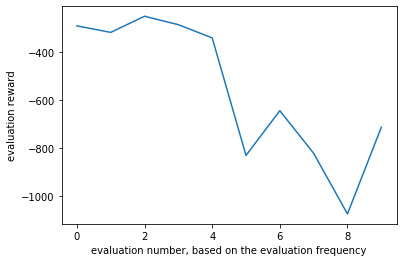

In [26]:
training(start_timesteps=1000,evaluation_frequency=1000,max_timesteps=10000,replay_buffer_size =5000, learning_rate = 0.0001)